# Simulate Topological Time Crystal

**Author:** Chenning Tao

**Date:** 13/4/2024

Based on paper "[Digital quantum simulation of Floquet symmetry-protected topological phases][1]"

[1]: https://www.nature.com/articles/s41586-022-04854-3


In this part, we will demonstrate how to simulate topology time crystal using Qiskit on our cloud platform and compare the simulated result with the real experiment result.

### Floquet Symmetry-protected Topological Time Phase（FSPT）

Time crystal is a quantum system of particles whose lowest-energy state is one in which the particles are in repetitive motion, which can be seen as a new phase. And topological time crystal introduced in the paper is floquet symmetry-proteded topological time phase, which is a non-equilibrium topological phase enabled by time-periodic driving.

These features are reflected on the time-periodic Hamiltonian of the qubits:
$$\begin{gathered}
H(t)= \begin{cases}H_1, & \text { for } 0 \leq t<T^{\prime}, \\
H_2, & \text { for } T^{\prime} \leq t<T,\end{cases} \\
H_1 \equiv\left(\frac{\pi}{2}-\delta\right) \sum_k \hat{\sigma}_k^x, \\
H_2 \equiv-\sum_k\left[J_k \hat{\sigma}_{k-1}^z \hat{\sigma}_k^x \hat{\sigma}_{k+1}^z+V_k \hat{\sigma}_k^x \hat{\sigma}_{k+1}^x+h_k \hat{\sigma}_k^x\right]
\end{gathered}$$
where H1 is the sum of on-body Pauli operators on different sites and introduces periodic driving, H2 includes interaction among neighboring sites, which introduces the subtle many-body properties in this system.


## Build circuit function for FSPT phase

The Hamiltonian mentioned above can be decomposed into the circuit shown in the figure.

<div style="text-align:center;">
    <img src="./pictures/4-2.circuit.png"  width="45%" height="45%">
</div>

The $H_1$ corresponds to the circuit in green background.

In [42]:
# import necessary dependencies
import qiskit
import numpy as np
from qiskit import *

# define the number of qubits, in this tutorial we use 8 qubits
num_qubits = 8

# construct the quantum circuit corrsponding to H1
def H1_FSPT(qc):
    # apply RX gates to all qubits with angle 0.99*pi
    for j in range(num_qubits):
        qc.rx(np.pi * 0.99, j)
    return qc

qc = QuantumCircuit(num_qubits)
print(H1_FSPT(qc))

     ┌────────────┐
q_0: ┤ Rx(3.1102) ├
     ├────────────┤
q_1: ┤ Rx(3.1102) ├
     ├────────────┤
q_2: ┤ Rx(3.1102) ├
     ├────────────┤
q_3: ┤ Rx(3.1102) ├
     ├────────────┤
q_4: ┤ Rx(3.1102) ├
     ├────────────┤
q_5: ┤ Rx(3.1102) ├
     ├────────────┤
q_6: ┤ Rx(3.1102) ├
     ├────────────┤
q_7: ┤ Rx(3.1102) ├
     └────────────┘


The $H_2$ corresponds to the circuit in yellow background. For the parameter of RY (Jk), we use randomly generated value from uniform distribution.

In [43]:
# construct the quantum circuit corrsponding to H2
from scipy.stats import uniform
# generate the parameter from uniform distribution
Jk = uniform.rvs(0, 2, size=num_qubits-2)
def H2_FSPT(qc, Jk):
    # apply CRZ, the control qubit is odd, the target qubit is even, angle is pi
    for j in range(1, num_qubits, 2):
        qc.crz(np.pi, j-1, j)
    # apply CRZ
    for j in range(2, num_qubits, 2):
        qc.crz(np.pi, j-1, j)

    # apply RY
    for j in range(1, num_qubits-1):
        qc.ry(-2*Jk[j-1], j)

    # apply CRZ
    for j in range(2, num_qubits, 2):
        qc.crz(-np.pi, j-1, j)

    for j in range(1, num_qubits, 2):
        qc.crz(-np.pi, j-1, j)

    return qc

# show the quantum circuit
qc = QuantumCircuit(num_qubits)
print(H2_FSPT(qc, rand_values))

                                                           
q_0: ────■───────────────────────────────────────────■─────
     ┌───┴───┐         ┌──────────────┐          ┌───┴────┐
q_1: ┤ Rz(π) ├────■────┤ Ry(-0.53346) ├────■─────┤ Rz(-π) ├
     └───────┘┌───┴───┐├─────────────┬┘┌───┴────┐└────────┘
q_2: ────■────┤ Rz(π) ├┤ Ry(-3.5922) ├─┤ Rz(-π) ├────■─────
     ┌───┴───┐└───────┘├─────────────┴┐└────────┘┌───┴────┐
q_3: ┤ Rz(π) ├────■────┤ Ry(-0.40565) ├────■─────┤ Rz(-π) ├
     └───────┘┌───┴───┐├─────────────┬┘┌───┴────┐└────────┘
q_4: ────■────┤ Rz(π) ├┤ Ry(-3.0076) ├─┤ Rz(-π) ├────■─────
     ┌───┴───┐└───────┘└┬────────────┤ └────────┘┌───┴────┐
q_5: ┤ Rz(π) ├────■─────┤ Ry(-1.667) ├─────■─────┤ Rz(-π) ├
     └───────┘┌───┴───┐┌┴────────────┴┐┌───┴────┐└────────┘
q_6: ────■────┤ Rz(π) ├┤ Ry(-0.35483) ├┤ Rz(-π) ├────■─────
     ┌───┴───┐└───────┘└──────────────┘└────────┘┌───┴────┐
q_7: ┤ Rz(π) ├───────────────────────────────────┤ Rz(-π) ├
     └───────┘                          

## Build the circuit

We build the circuit using the above function according to the time step and add some initialization and measurement for the circuit.

In [44]:
def build_circuit(n, Jk):
    qc = QuantumCircuit(num_qubits)

    reversed = []
    # initialize the quantum state random orthogonal state of |0> and |1>
    for i in range(0, num_qubits):
        if np.random.rand() > 0.5:
            qc.x(i)
            reversed.append(num_qubits-i-1)
            
    # build circuit
    for i in range(1, n+1):
        # if is odd
        if i % 2 == 1:
            qc = H1_FSPT(qc)
        else:
            qc = H2_FSPT(qc, Jk)

    qc.measure_all()
    return qc, reversed

# generate the parameter from uniform distribution
Jk = uniform.rvs(0, 2, size=num_qubits-2)
# generate the circuit and get the reversed qubits
qc, reversed = build_circuit(2, Jk)
print(qc)

        ┌────────────┐                                                »
   q_0: ┤ Rx(3.1102) ├──────■─────────────────────────────────────────»
        ├────────────┤  ┌───┴───┐                     ┌─────────────┐ »
   q_1: ┤ Rx(3.1102) ├──┤ Rz(π) ├────────────────■────┤ Ry(-1.7142) ├─»
        └───┬───┬────┘┌─┴───────┴──┐         ┌───┴───┐├─────────────┤ »
   q_2: ────┤ X ├─────┤ Rx(3.1102) ├────■────┤ Rz(π) ├┤ Ry(-2.3778) ├─»
        ┌───┴───┴────┐└────────────┘┌───┴───┐└───────┘├─────────────┤ »
   q_3: ┤ Rx(3.1102) ├──────────────┤ Rz(π) ├────■────┤ Ry(-3.9469) ├─»
        ├────────────┤              └───────┘┌───┴───┐├─────────────┤ »
   q_4: ┤ Rx(3.1102) ├──────────────────■────┤ Rz(π) ├┤ Ry(-3.7591) ├─»
        └───┬───┬────┘┌────────────┐┌───┴───┐└───────┘├─────────────┴┐»
   q_5: ────┤ X ├─────┤ Rx(3.1102) ├┤ Rz(π) ├────■────┤ Ry(-0.78984) ├»
            ├───┤     ├────────────┤└───────┘┌───┴───┐├─────────────┬┘»
   q_6: ────┤ X ├─────┤ Rx(3.1102) ├────■────┤ Rz(π) ├┤ Ry(-1.47

## Build noise model
For more realistic simualtion, we add pauli noise for one bit gate and two bit gate.

In [45]:
def build_noise_model(e1, e2):
    error_1 = pauli_error([('X', e1/3), ('Y', e1/3), ('Z', e1/3),('I',1-e1)])
    error_2 = pauli_error([('XX', e2/15), ('XY', e2/15), ('XZ', e2/15), 
                        ('YX', e2/15), ('YY', e2/15), ('YZ', e2/15), 
                        ('ZX', e2/15), ('ZY', e2/15), ('ZZ', e2/15), 
                        ('II',1-9/15*e2)])

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_1, ['rx', 'ry'])
    noise_model.add_all_qubit_quantum_error(error_2, ['cz'])
    return noise_model

## Caculate the expection result
For each duration of time step, we caculate the expection based on the measurement result.

$$\overline{\left\langle\sigma_j^z(t)\right\rangle} = p_0 - p_1 = 1 - 2\times p_1$$

In [46]:
# calculate the expectation value of the Z operator
def expectation_value(res, i, reversed):
    total_counts = sum(res.values())
    p1 = 0
    for bitstring, count in res.items():
        if bitstring[i] == '1':
            p1 += count / total_counts
    if i in reversed:
        return -(1-2*p1)
    return 1 - 2*p1

## Simulating
With the above functions, we can run a single simualtion with the defined number of time step.

In [47]:
from qiskit import execute
from qiskit_aer.noise import NoiseModel, pauli_error
import qiskit_aer

# generate the parameter from uniform distribution
Jk = uniform.rvs(0, 2, size=num_qubits-2)
# generate the circuit and get the reversed qubits
qc, reversed = build_circuit(2, Jk)

# generate the noise
noise_model = build_noise_model(0.006, 0.01)

# run the simulation on qasm backent
backend = qiskit_aer.Aer.get_backend('qasm_simulator')
qc = transpile(qc, backend, basis_gates=['rx', 'ry', 'cz', 'x'])
res = backend.run(qc, shots=100, noise_model=noise_model).result().get_counts()

## Draw the result

We can compare our result with the experiment result. For each point in the figure, we generate and run teh circuit for 100 times (ATTENTION: this could take a while!).

<div style="text-align:center;">
    <img src="./pictures/4-2.result.png"  width="50%" height="50%">
</div>

In [53]:
def collect_result(num_timestep, noise_model, dis_pram):
    res = []
    # collect the result for time step from 1 to num_timestep
    for i in range(0, num_timestep):
        # repeat 100 times
        res0 = 0
        res_mid = 0
        res7 = 0
        repeat_time = 20
        for _ in range(repeat_time):
            # generate the parameter from uniform distribution
            Jk = uniform.rvs(0, dis_pram, size=num_qubits-2)
            qc, reversed = build_circuit(i, Jk)
            qc = transpile(qc, backend)
            result = backend.run(qc, shots=100, noise_model=noise_model).result().get_counts()
            res_0 = expectation_value(result, 0, reversed)
            mid = 0
            for j in range(1, num_qubits-1):
                mid += expectation_value(result, j, reversed)
            res_7 = expectation_value(result, num_qubits-1, reversed)
            res0 += res_0
            res7 += res_7
            res_mid += mid / (num_qubits-2)
        res0 /= repeat_time
        res_mid /= repeat_time
        res7 /= repeat_time
        res.append([res0, res7, res_mid])
    return res

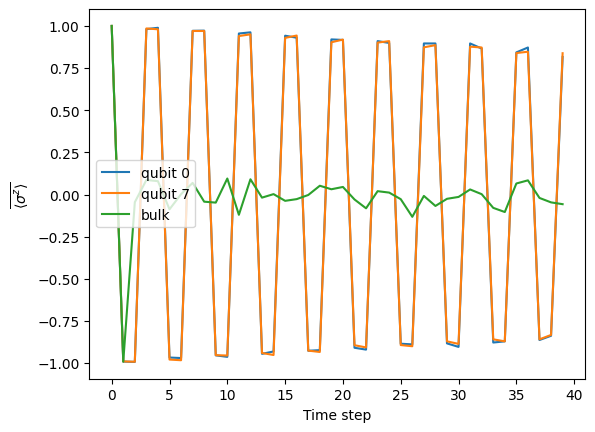

In [56]:
import matplotlib.pyplot as plt

res = collect_result(40, noise_model, dis_pram=2)
# plot the result
plt.plot(res)
plt.xlabel('Time step')
plt.ylabel(r'$\overline{\left\langle\sigma^z\right\rangle}$')
plt.legend(['qubit 0', 'qubit 7', 'bulk'])
plt.show()

And we can see the experiment result in the left. The y-axis is the expectation of $\sigma_z$, which is equal to $P_0 – P_1$. We can see from the figure that for topological time crystal, only the qubits on the edge show period oscillation, while the inner qubits show no apparent pattern. And for the normal thermal phase, all qubits show no apparent pattern.


## Some parameters
We can change some parameters and see the result.

### 1. initial state
The result will look same for different initial state. In the `build circuit` function, we have set the state to inital randomly by applying X gate to random qubti.

### 2. noise
We can set different Pauli error rates. With a higher error rate, qubit 0 and qubit 7 decay will seem more severe.

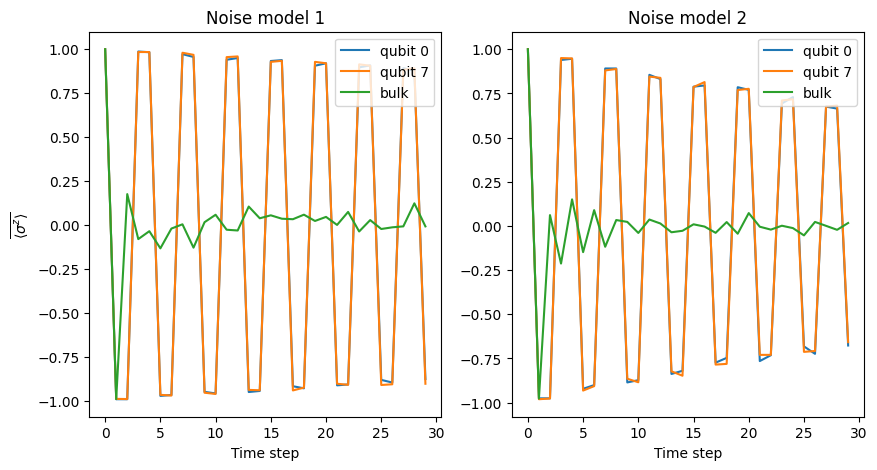

In [64]:
noise_model1 = build_noise_model(0.006, 0.01)
noise_model2 = build_noise_model(0.02, 0.04)
res1 = collect_result(30, noise_model1, dis_pram=2)
res2 = collect_result(30, noise_model2, dis_pram=2)
# draw two subplots in one figure, two subplots in parallel
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(res1)
axs[0].set_title('Noise model 1')
axs[0].set_xlabel('Time step')
axs[0].set_ylabel(r'$\overline{\left\langle\sigma^z\right\rangle}$')
axs[0].legend(['qubit 0', 'qubit 7', 'bulk'])
axs[1].plot(res2)
axs[1].set_title('Noise model 2')
axs[1].set_xlabel('Time step')
axs[1].legend(['qubit 0', 'qubit 7', 'bulk'])
plt.show()


### 3. the distribution of Jk
The parameter $J_k$ represents the potency of many-body localization. A certain alteration won't impact the outcome. (The magnitude of the change that would lead to a substantial influence remains unexplored in our study.)

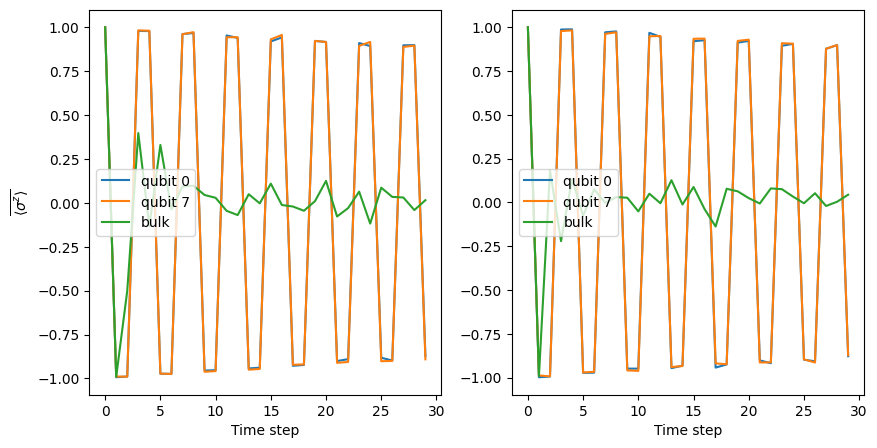

In [65]:
noise_model = build_noise_model(0.006, 0.01)
res1 = collect_result(30, noise_model, dis_pram=1)
res2 = collect_result(30, noise_model, dis_pram=2)
# draw two subplots in one figure, two subplots in parallel
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(res1)
axs[0].set_xlabel('Time step')
axs[0].set_ylabel(r'$\overline{\left\langle\sigma^z\right\rangle}$')
axs[0].legend(['qubit 0', 'qubit 7', 'bulk'])
axs[1].plot(res2)
axs[1].set_xlabel('Time step')
axs[1].legend(['qubit 0', 'qubit 7', 'bulk'])
plt.show()